In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from datetime import date, timedelta
import timeit, functools
from tqdm.auto import tqdm

import mechafil.data as mecha_data
import mechafil.data_spacescope as data_spacescope
from mechafil.data import get_historical_network_stats, get_sector_expiration_stats, setup_spacescope
from mechafil.power import (
    forecast_power_stats,
    build_full_power_stats_df,
    scalar_or_vector_to_vector,
    compute_day_se_power,
    compute_basic_day_renewed_power
)

import matplotlib.pyplot as plt

In [3]:
import jax
from jax import lax
import jax.numpy as jnp
import gc

In [4]:
setup_spacescope('/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json')
spacescope_obj = data_spacescope.SpacescopeDataConnection('/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json')

In [5]:
forecast_length = 360*5
start_date = date(2021, 3, 16)
current_date = date.today() - timedelta(days=2)
end_date = current_date + timedelta(days=forecast_length)

In [6]:
# Get sector scheduled expirations
res = get_sector_expiration_stats(start_date, current_date, end_date)
rb_known_scheduled_expire_vec = res[0]
qa_known_scheduled_expire_vec = res[1]
known_scheduled_pledge_release_full_vec = res[2]
# Get daily stats
fil_stats_df = get_historical_network_stats(start_date, current_date, end_date)
current_day_stats = fil_stats_df[fil_stats_df["date"] >= current_date].iloc[0]
# Forecast power stats
rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0

scheduled_df = spacescope_obj.query_spacescope_sector_expirations(start_date, end_date)

In [7]:
rr = 0.6
rbp = 10
duration = 360

num_mc = 100
forecast_length_yrs_vec = range(1,20)

In [8]:
def compute_se_rr_naive(day_rb_scheduled_expire_power, 
                        day_rb_renewed_power, 
                        rb_onboard_vec, 
                        rr_vec,
                        rb_known_sched_expire,
                        forecast_length):
    for day_i in range(forecast_length):
        # Raw-power stats
        day_rb_scheduled_expire_power[day_i] = compute_day_se_power(
            day_i,
            rb_known_sched_expire,
            rb_onboard_vec,
            day_rb_renewed_power,
            duration,
        )
        day_rb_renewed_power[day_i] = compute_basic_day_renewed_power(
            day_i, day_rb_scheduled_expire_power, rr_vec
        )

In [9]:
# Time the naive version

# allocate arrays
max_forecast_len_days = max(forecast_length_yrs_vec) * 365
day_rb_scheduled_expire_power = np.zeros(max_forecast_len_days)
day_rb_renewed_power = np.zeros(max_forecast_len_days)
renewal_rate_vec = rr * np.ones(max_forecast_len_days)
day_rb_onboarded_power = rbp * np.ones(max_forecast_len_days)

# the traditional loop
naive_speeds = []
for forecast_length_yrs in tqdm(forecast_length_yrs_vec):
    forecast_length_days = forecast_length_yrs*365
    t = timeit.Timer(
        functools.partial(compute_se_rr_naive, 
                          day_rb_scheduled_expire_power, 
                          day_rb_renewed_power, 
                          day_rb_onboarded_power,
                          renewal_rate_vec,
                          rb_known_scheduled_expire_vec,
                          forecast_length_days
                         ),
    )
    naive_speeds.append(t.timeit(num_mc)/num_mc)

  0%|          | 0/19 [00:00<?, ?it/s]

In [10]:
def basic_scalar_renewed_power(day_sched_expire_power, renewal_rate):
    return day_sched_expire_power * renewal_rate

def have_known_se_sector_info(arggs):
    known_scheduled_expire_vec, day_i = arggs
    return known_scheduled_expire_vec[day_i]

def dont_have_known_se_sector_info(arggs):
    return 0.0

def have_modeled_sector_expiration_info(arggs):
    day_onboard_vec, day_renewed_vec, day_i, duration = arggs
    return day_onboard_vec[day_i - duration] + day_renewed_vec[day_i - duration]

def dont_have_modeled_sector_expiration_info(arggs):
    return 0.0

def jax_compute_day_se_power(
    day_i,
    known_scheduled_expire_vec,
    day_onboard_vec,
    day_renewed_vec,
    duration,
):
    # Scheduled expirations coming from known active sectors
    pred = day_i > len(known_scheduled_expire_vec) - 1
    known_day_se_power = lax.cond(
        pred, 
        dont_have_known_se_sector_info,
        have_known_se_sector_info, 
        (known_scheduled_expire_vec, day_i)
     )
    
    pred = day_i - duration >= 0
    model_day_se_power = lax.cond(
        pred,
        have_modeled_sector_expiration_info,
        dont_have_modeled_sector_expiration_info,
        (day_onboard_vec, day_renewed_vec, day_i, duration)
    )
    
    # Total scheduled expirations
    day_se_power = known_day_se_power + model_day_se_power
    return day_se_power

def compute_se_rr_naive_jax(day_rb_scheduled_expire_power, 
                            day_rb_renewed_power, 
                            rb_onboard_vec, 
                            rr_vec,
                            rb_known_sched_expire,
                            forecast_length):
    for day_i in range(forecast_length):
        # Raw-power stats
        se_power_day_i = jax_compute_day_se_power(
            day_i,
            rb_known_sched_expire,
            rb_onboard_vec,
            day_rb_renewed_power,
            duration,
        )
        renew_day_i = basic_scalar_renewed_power(
            se_power_day_i, rr_vec[day_i]
        )
        
        day_rb_scheduled_expire_power = day_rb_scheduled_expire_power.at[day_i].set(se_power_day_i)
        day_rb_renewed_power = day_rb_renewed_power.at[day_i].set(renew_day_i)
        
    return day_rb_scheduled_expire_power, day_rb_renewed_power

In [11]:
def compute_se(carry, x):
    day_rb_renewed_power_vec, rb_known_sched_expire, day_rb_onboarded_power, day_i, duration = carry
    
    # compute the components of SE power
    # known SE
    pred = day_i > len(rb_known_sched_expire) - 1
    known_day_se_power = lax.cond(
        pred, 
        dont_have_known_se_sector_info,
        have_known_se_sector_info, 
        (rb_known_sched_expire, day_i)
     )
    
    pred = day_i - duration >= 0
    model_day_se_power = lax.cond(
        pred,
        have_modeled_sector_expiration_info,
        dont_have_modeled_sector_expiration_info,
        (day_rb_onboarded_power, day_rb_renewed_power_vec, day_i, duration)
    )
    day_se_power = known_day_se_power + model_day_se_power
    
    # compute new renewed power
    day_i_rb_renewed_power = day_se_power * rr
    # need to set arrays in this manner -> when using jit, this is guaranteed to become inplace
    day_rb_renewed_power_vec = day_rb_renewed_power_vec.at[day_i].set(day_i_rb_renewed_power)
    
    return (day_rb_renewed_power_vec, rb_known_sched_expire, day_rb_onboarded_power, day_i+1, duration), day_se_power

# create a JIT version of it
compute_se_jit = jax.jit(compute_se)

In [12]:
# Time the naive JAX version

# allocate arrays
max_forecast_len_days = max(forecast_length_yrs_vec) * 365
day_rb_scheduled_expire_power = jnp.zeros(max_forecast_len_days)
day_rb_renewed_power = jnp.zeros(max_forecast_len_days)
renewal_rate_vec = rr * jnp.ones(max_forecast_len_days)
day_rb_onboarded_power = rbp * jnp.ones(max_forecast_len_days)

# the traditional loop
naive_jax_speeds = []
for forecast_length_yrs in tqdm(forecast_length_yrs_vec):
    forecast_length_days = forecast_length_yrs*365
    t = timeit.Timer(
        functools.partial(compute_se_rr_naive_jax, 
                          day_rb_scheduled_expire_power, 
                          day_rb_renewed_power, 
                          day_rb_onboarded_power,
                          renewal_rate_vec,
                          rb_known_scheduled_expire_vec,
                          forecast_length_days
                         ),
    )
    naive_jax_speeds.append(t.timeit(2)/2)

  0%|          | 0/19 [00:00<?, ?it/s]

In [19]:
# Time the pure-JAX version w/out JIT
def pure_jax_wrapper(forecast_length, duration):
    # wrapper so that we can call the timeit function
    init_in = (day_rb_renewed_power_vec, rb_known_scheduled_expire_vec, day_rb_onboarded_power, 0, duration)
    ret, day_rb_scheduled_expire_power_jax2 = lax.scan(compute_se, init_in, None, length=forecast_length)

def pure_jax_with_jit_wrapper(forecast_length, duration):
    # wrapper so that we can call the timeit function
    init_in = (day_rb_renewed_power_vec, rb_known_scheduled_expire_vec, day_rb_onboarded_power, 0, duration)
    ret, day_rb_scheduled_expire_power_jax2 = lax.scan(compute_se_jit, init_in, None, length=forecast_length)

max_forecast_len_days = max(forecast_length_yrs_vec) * 365
day_rb_onboarded_power = rbp * jnp.ones(max_forecast_len_days)
day_rb_renewed_power_vec = jnp.zeros(len(day_rb_onboarded_power))
    
jax_speeds = []
for forecast_length_yrs in tqdm(forecast_length_yrs_vec):
    forecast_length_days = forecast_length_yrs*365
    t = timeit.Timer(
        functools.partial(pure_jax_wrapper, 
                          forecast_length_days,
                          duration
                         ),
    )
    jax_speeds.append(t.timeit(num_mc)/num_mc)
    
jax_with_jit_speeds = []
for forecast_length_yrs in tqdm(forecast_length_yrs_vec):
    forecast_length_days = forecast_length_yrs*365
    t = timeit.Timer(
        functools.partial(pure_jax_with_jit_wrapper, 
                          forecast_length_days,
                          duration
                         ),
    )
    jax_with_jit_speeds.append(t.timeit(num_mc)/num_mc)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [14]:
# compute all variants and compare in one plot
forecast_length = 5*365

renewal_rate_vec = rr * np.ones(forecast_length)
day_rb_onboarded_power = rbp * np.ones(forecast_length)

# naive 
day_rb_scheduled_expire_power_naive = np.zeros(forecast_length)
day_rb_renewed_power_naive = np.zeros(forecast_length)
compute_se_rr_naive(day_rb_scheduled_expire_power_naive, 
                    day_rb_renewed_power_naive, 
                    day_rb_onboarded_power, 
                    renewal_rate_vec,
                    rb_known_scheduled_expire_vec,
                    forecast_length)

# naive jax
day_rb_scheduled_expire_power_jax1 = jnp.zeros(forecast_length)
day_rb_renewed_power_jax1 = jnp.zeros(forecast_length)
day_rb_scheduled_expire_power_jax1, day_rb_renewed_power_jax1 = compute_se_rr_naive_jax(
    day_rb_scheduled_expire_power_jax1, 
    day_rb_renewed_power_jax1, 
    day_rb_onboarded_power, 
    renewal_rate_vec,
    rb_known_scheduled_expire_vec,
    forecast_length
)

# jax w/ lax.scan + jit
day_rb_renewed_power_vec = jnp.zeros(len(day_rb_onboarded_power))
init_in = (day_rb_renewed_power_vec, rb_known_scheduled_expire_vec, day_rb_onboarded_power, 0, duration)
ret, day_rb_scheduled_expire_power_jax2 = lax.scan(compute_se_jit, init_in, None, length=forecast_length)
day_rb_renewed_power_jax2 = ret[0]

<IPython.core.display.Javascript object>


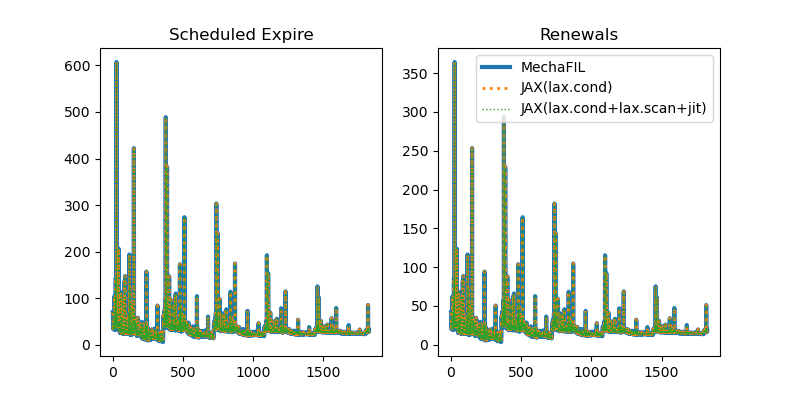

In [15]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title('Scheduled Expire')
plt.plot(range(forecast_length), day_rb_scheduled_expire_power_naive, linewidth=3, label='MechaFIL')
plt.plot(range(forecast_length), day_rb_scheduled_expire_power_jax1, linewidth=2, linestyle=':', label='JAX(lax.cond)')
plt.plot(range(forecast_length), day_rb_scheduled_expire_power_jax2, linewidth=1, linestyle=':', label='JAX(lax.cond+lax.scan+jit)')

plt.subplot(1,2,2)
plt.title('Renewals')
plt.plot(range(forecast_length), day_rb_renewed_power_naive, linewidth=3, label='MechaFIL')
plt.plot(range(forecast_length), day_rb_renewed_power_jax1, linewidth=2, linestyle=':', label='JAX(lax.cond)')
plt.plot(range(forecast_length), day_rb_renewed_power_jax2, linewidth=1, linestyle=':', label='JAX(lax.cond+lax.scan+jit)')
plt.legend()

<IPython.core.display.Javascript object>


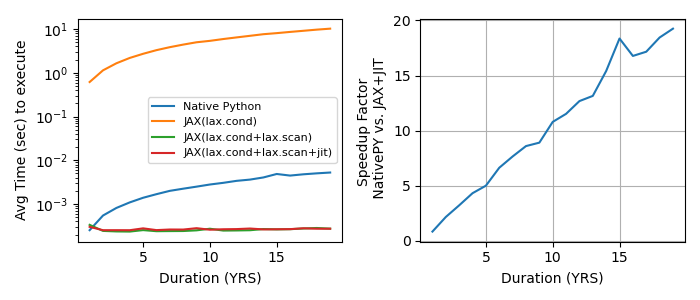

In [20]:
# plot the speeds
plt.figure(figsize=(7,3))

plt.subplot(1,2,1)
plt.plot(forecast_length_yrs_vec, naive_speeds, label='Native Python')
plt.plot(forecast_length_yrs_vec, naive_jax_speeds, label='JAX(lax.cond)')
plt.plot(forecast_length_yrs_vec, jax_speeds, label='JAX(lax.cond+lax.scan)')
plt.plot(forecast_length_yrs_vec, jax_with_jit_speeds, label='JAX(lax.cond+lax.scan+jit)')
plt.yscale('log')
plt.xlabel('Duration (YRS)')
plt.ylabel('Avg Time (sec) to execute')
plt.legend(fontsize=8)

plt.subplot(1,2,2)
plt.plot(forecast_length_yrs_vec, np.asarray(naive_speeds)/np.asarray(jax_with_jit_speeds))
plt.ylabel('Speedup Factor \n NativePY vs. JAX+JIT')
plt.xlabel('Duration (YRS)')
plt.grid()

plt.tight_layout()